In [160]:
import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from copia.data import to_copia_dataset
from copia.estimators import diversity
from copia.rarefaction_extrapolation import species_accumulation
from copia.plot import accumulation_curve

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv('unseen_species_model/individuals_into_unseen_plus_>3.csv')

df["count"] = df["count_works"]
df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})]  # Not more ?
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})

df_distribution = df_m[['individual_wikidata_id','occupation']].drop_duplicates()
df_distribution.occupation.value_counts()

df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})

# knots
num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)
iknots = knots[1:-1]

sample = df_m.copy()

sample['count_works'][sample['count_works']==0] = 1

In [161]:

#sample = sample.sample(20000, random_state=42)

# ===== CHAO1 CALCULATION USING THE SAME KNOTS =====

# Create time bins using the same knots approach
time_bins = knots
time_labels = [f"{int(time_bins[i])}-{int(time_bins[i+1])}" for i in range(len(time_bins)-1)]

# Convert century to decade for consistency (or use century directly)
if 'decade' not in sample.columns:
    sample['decade'] = sample['century'] * 10  # Convert century to decade midpoint

# Create time period groupings using the knots
sample['time_period'] = pd.cut(sample['century'], 
                              bins=time_bins, 
                              labels=time_labels, 
                              include_lowest=True)

print(f"Knots used: {knots}")
print(f"Time periods created: {time_labels}")


# Initialize results list for Chao1 calculations
# Initialize results list for Chao1 calculations
chao1_results = []

# Process each region separately
for region in tqdm(sample['region_name'].unique(), desc="Processing regions"):
    region_data = sample[sample['region_name'] == region]
    
    # Group by time period and occupation
    groups = region_data.groupby(['time_period', 'occupation'])
    
    # Iterate through each group
    for (time_period, occupation), group_data in groups:
        # Skip if time_period is NaN
        if pd.isna(time_period):
            continue
            
        # Get counts for unique individuals in this group
        # Use count_works as the abundance measure
        df_unique = group_data[['individual_wikidata_id', 'count_works']].drop_duplicates()
        
   
        # Prepare abundance data for Chao1
        individual_counts = df_unique.set_index('individual_wikidata_id')['count_works']
        individual_counts.index.name = None
        
  
        # Convert to copia dataset
        ds = to_copia_dataset(individual_counts, data_type="abundance", input_type="counts")
        
        # Calculate only Chao1
        chao1 = round(diversity(ds, method='chao1'))
        
        # Calculate observed richness
        observed_richness = len(individual_counts)
        
        # Get time period boundaries (with error handling)
        try:
            period_start = float(time_period.split('-')[0])
            period_end = float(time_period.split('-')[1])
            period_midpoint = (period_start + period_end) / 2
        except (ValueError, IndexError):
            # Skip if time_period format is invalid
            continue
        
        # Count f1 and f2 (singletons and doubletons)
        f1 = sum(individual_counts == 1)  # Singletons
        f2 = sum(individual_counts == 2)  # Doubletons
        
        # Add to results
        chao1_results.append({
            'region_name': region,
            'time_period': time_period,
            'period_start': period_start,
            'period_end': period_end,
            'period_midpoint': period_midpoint,
            'occupation': occupation,
            'observed_richness': observed_richness,
            'total_records': len(group_data),
            'unique_individuals': len(df_unique),
            'f1_singletons': f1,
            'f2_doubletons': f2,
            'total_abundance': individual_counts.sum(),
            'chao1': chao1,
            'chao1_bias': chao1 - observed_richness,  # How much Chao1 exceeds observed
        })

# Create DataFrame from results
df_chao1_estimates = pd.DataFrame(chao1_results)

# Sort by region, time period, occupation
df_chao1_estimates = df_chao1_estimates.sort_values(['region_name', 'period_start', 'occupation'])
df_chao1_estimates


Knots used: [-800. -500. -200.  100.  400.  700. 1000. 1300. 1600. 1900.]
Time periods created: ['-800--500', '-500--200', '-200-100', '100-400', '400-700', '700-1000', '1000-1300', '1300-1600', '1600-1900']


Processing regions: 100%|██████████| 24/24 [00:00<00:00, 47.25it/s]


,region_name,time_period,period_start,period_end,period_midpoint,occupation,observed_richness,total_records,unique_individuals,f1_singletons,f2_doubletons,total_abundance,chao1,chao1_bias
159,Arabic world,100-400,100.00,400.00,250.00,Musician,1,1,1,1,0,1.00,1,0
160,Arabic world,100-400,100.00,400.00,250.00,Writer,45,45,45,39,6,51.00,169,124
161,Arabic world,400-700,400.00,700.00,550.00,Architect,1,1,1,1,0,1.00,1,0
162,Arabic world,400-700,400.00,700.00,550.00,Musician,2,2,2,2,0,2.00,2,0
163,Arabic world,400-700,400.00,700.00,550.00,Writer,85,87,85,81,4,89.00,896,811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,United Kingdom,1600-1900,1600.00,1900.00,1750.00,Musician,1242,1243,1242,1231,11,1253.00,70067,68825
197,United Kingdom,1600-1900,1600.00,1900.00,1750.00,Painter,2180,2180,2180,1926,254,2434.00,9479,7299
198,United Kingdom,1600-1900,1600.00,1900.00,1750.00,Performing Artist,258,259,258,246,12,270.00,2770,2512
199,United Kingdom,1600-1900,1600.00,1900.00,1750.00,Sculptor,363,364,363,312,51,414.00,1315,952


In [162]:

import warnings

warnings.filterwarnings("ignore", message="Add-one smoothing for f4 = 0")
warnings.filterwarnings("ignore", category=FutureWarning)


import pandas as pd

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt

from copia.data import to_copia_dataset
from copia.estimators import diversity
from copia.rarefaction_extrapolation import species_accumulation
from copia.plot import accumulation_curve

Copia is a statistical software package for estimating diversity and richness on the basis of abundance data. The package contains several bias-correcting richness estimators, such as the Chao1 and the Jacknife estimator.

In [163]:
remove_regions = ['Southwestern Europe', 'Northwestern Europe', 'Southern China', 'Southern Japan', 'Northern China', 'Northern Japan']

In [164]:
# observations = 'duck', 'duck', 'eagle', 'dove', 'dove', 'dove', 'hawk', 'dove', 'dove'
# ds = to_copia_dataset(observations, data_type="abundance", input_type="observations")

# for method in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
#     print(method, '->', round(diversity(ds, method=method)))

# D = diversity(ds, method='chao1', CI=True, n_iter=100, n_jobs=1)

# accumulation = species_accumulation(ds, max_steps=1000, n_iter=100, step_size=10)
# fig, ax = plt.subplots(figsize=(6, 4))

# accumulation_curve(
#     ds, accumulation, ax=ax, xlabel="number of documents", ylabel="number of works");

#### Apply on normal data

In [165]:


df = pd.read_csv('unseen_species_model/unseen_species_model_bayesian.csv', index_col=[0])

sample = df.copy()
sample['count'] = sample['count'].astype(int)
#sample = sample.sample(2000, random_state=42)
sample['count'][sample['count']==0] = 1



# sample[sample['region_name']=='German world']

# sample['count_works'][sample['count_works']==0] = 1
# sample = sample[['individual_wikidata_id', 'decade', 'count_works', 'occupation']]
# sample.copy()

In [166]:
df_test = sample[sample['region_name']=='German world']
df_test = df_test[['individual_wikidata_id','decade', 'count']]
df_test = df_test[df_test['decade']==1850]
df_test

individual_counts = df_test.set_index('individual_wikidata_id')['count']
individual_counts
ds = to_copia_dataset(individual_counts, data_type="abundance", input_type="counts")
chao1 = round(diversity(ds, method='chao1'))
chao1

24465

In [167]:


# Initialize results list
results = []

# Process each region separately
for region in sample['region_name'].unique():
    region_data = sample[sample['region_name'] == region]
    
    # Group by decade and occupation directly (no binning)
    groups = region_data.groupby(['decade', 'occupation'])
    
    # Iterate through each group
    for (decade, occupation), group_data in groups:
        # Get counts for unique individuals in this group
        df_unique = group_data[['individual_wikidata_id', 'count']].drop_duplicates()
        
        individual_counts = df_unique.set_index('individual_wikidata_id')['count']
        individual_counts.index.name = None
        ds = to_copia_dataset(individual_counts, data_type="abundance", input_type="counts")
        
        chao1 = round(diversity(ds, method='chao1'))
        jackknife = round(diversity(ds, method='jackknife'))
        ichao1 = round(diversity(ds, method='ichao1'))
        # ace = round(diversity(ds, method='ace'))
        # egghe_proot = round(diversity(ds, method='egghe_proot')) #not stable
        
        # Add to results
        results.append({
            'region_name': region,
            'decade': decade,  # Use actual decade instead of binned value
            'occupation': occupation,
            'f1': ds.f1,
            'f2': ds.f2,
            'n': ds.n,
            'chao1': chao1,
            'jackknife': jackknife,
            'ichao1': ichao1,
            # 'ace': ace,
            # 'egghe_proot': egghe_proot
        })

# Create DataFrame from results
df_estimator = pd.DataFrame(results)

# Sort by region, decade, occupation
df_estimator = df_estimator.sort_values(['region_name', 'decade', 'occupation'])

df_estimator

,region_name,decade,occupation,f1,f2,n,chao1,jackknife,ichao1
2567,Arabic world,-610,Writer,1,0,1,1,1,1
2568,Arabic world,-400,Painter,1,0,1,1,1,1
2569,Arabic world,-360,Painter,1,0,1,1,1,1
2570,Arabic world,-360,Writer,1,1,3,2,3,2
2571,Arabic world,-330,Writer,0,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...
3075,United Kingdom,1880,Musician,170,2,174,7355,342,7355
3076,United Kingdom,1880,Painter,377,37,451,2330,791,2330
3077,United Kingdom,1880,Performing Artist,33,1,35,563,67,563
3078,United Kingdom,1880,Sculptor,17,9,35,42,43,42


In [168]:
df_plot = df.copy()
df_plot = df_plot[['region_name', 'decade', 'occupation', 'f1', 'f2', 'f0']]
df_plot = df_plot.rename(columns={'f0':'gen_chao'})
df_plot['gen_chao'] = df_plot['gen_chao'].astype(int)
df_plot = df_plot.groupby(['region_name','decade', 'occupation']).sum().reset_index()
df_plot = pd.merge(df_plot, df_estimator, on = ['region_name', 'decade', 'occupation', 'f1', 'f2'])
df_plot['compare'] = df_plot['gen_chao'] <= df_plot['chao1']
# df_plot[df_plot['compare']==True]
df_plot['compare'] = df_plot['gen_chao'] < df_plot['chao1']

df_plot[df_plot['compare']==True]


,region_name,decade,occupation,f1,f2,gen_chao,n,chao1,jackknife,ichao1,compare
31,Arabic world,140,Writer,9,0,36,9,41,9,41,True
36,Arabic world,240,Writer,7,0,21,7,25,7,25,True
47,Arabic world,400,Writer,6,0,12,6,18,6,18,True
49,Arabic world,440,Writer,6,0,12,6,18,6,18,True
87,Arabic world,840,Writer,10,1,55,12,57,21,57,True
...,...,...,...,...,...,...,...,...,...,...,...
5575,United Kingdom,1870,Painter,234,23,514,280,1443,491,1443,True
5576,United Kingdom,1870,Performing Artist,21,1,176,23,233,43,233,True
5579,United Kingdom,1880,Architect,78,2,1200,82,1582,158,1582,True
5581,United Kingdom,1880,Painter,377,37,828,451,2330,791,2330,True


### Compare estimators

In [169]:
df_gen_chao_regions= pd.read_csv('unseen_species_model/df_gen_chao_regions_estimations.csv', index_col = [0])
df_gen_chao_regions = df_gen_chao_regions[['region_name', 'f0 ("unseen species")']]
df_gen_chao_regions = df_gen_chao_regions.rename(columns={'f0 ("unseen species")':'gen_chao'})
df_gen_chao_regions


df_compare = df_plot.groupby('region_name')[['chao1', 'gen_chao', 'jackknife']].sum().reset_index()
df_compare['gen_chao'] = df_compare['gen_chao'].astype(int)
df_compare = df_compare.drop('gen_chao', axis=1)
df_compare = pd.merge(df_compare, df_gen_chao_regions, on = 'region_name')
df_compare = df_compare[['region_name', 'gen_chao', 'chao1', 'jackknife']]
df_compare

,region_name,gen_chao,chao1,jackknife
0,Arabic world,9814,7317,1687
1,Central Europe,335099,231145,14326
2,Chinese world,10605,14139,2269
3,France,264692,229179,32301
4,German world,932397,1060441,53619
5,Greek World,14033,6241,1489
6,Indian world,3462,1593,543
7,Italy,411813,307258,24455
8,Japan,8482,6325,1339
9,Korea,1894,301,201


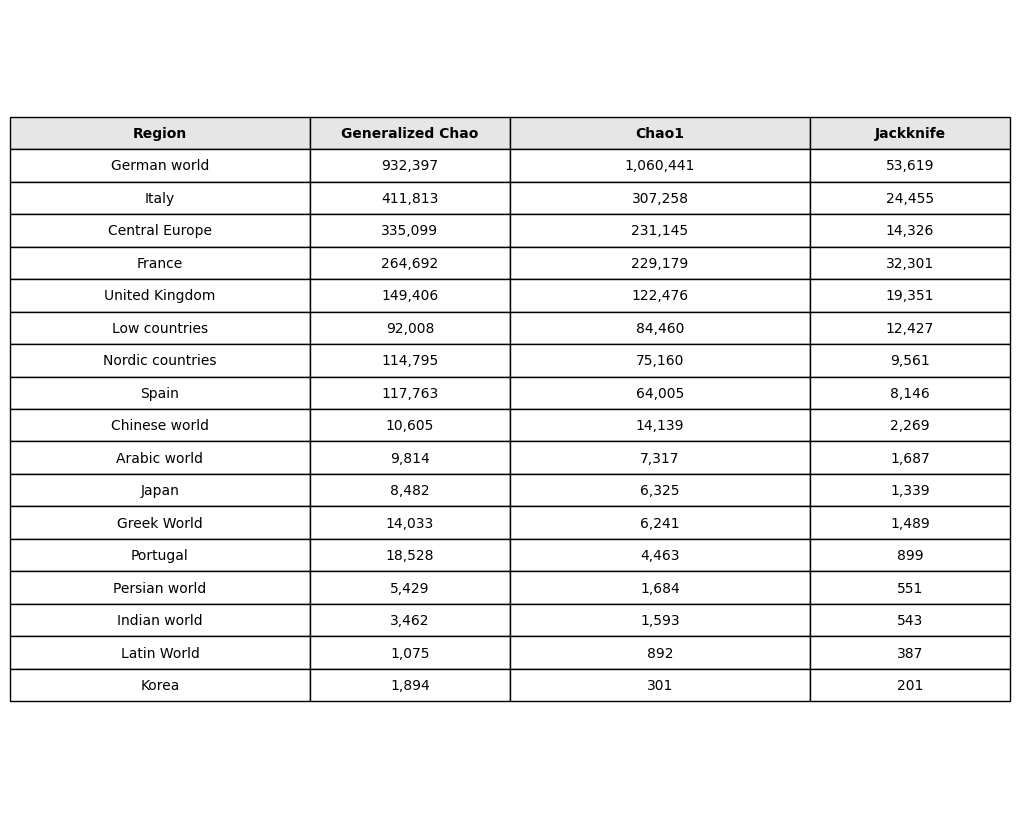

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

# Assuming df_compare is already created and contains your data
# Sort by Chao1 values (descending)
df_sorted = df_compare.sort_values('chao1', ascending=False).copy()


remove_regions = ['Southwestern Europe', 'Northwestern Europe', 'Southern China', 'Southern Japan', 'Northern China', 'Northern Japan']

df_sorted = df_sorted[~df_sorted['region_name'].isin(remove_regions)]

# Format numbers with thousands separator
for col in ['chao1', 'gen_chao', 'jackknife']:
    df_sorted[col] = df_sorted[col].apply(lambda x: f"{x:,}")


# Rename columns for publication
df_sorted.columns = ['Region', 'Generalized Chao', 'Chao1', 'Jackknife']

# Create a figure and axis - reduce the figure height to eliminate padding
fig, ax = plt.subplots(figsize=(10, 8))  # Reduce height from 12 to 8

# Turn off the axis
ax.axis('off')

# Create the table with position adjustments to remove padding
table = ax.table(
    cellText=df_sorted.values,
    colLabels=df_sorted.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.3, 0.2, 0.3, 0.2]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Style header row
for i, key in enumerate(df_sorted.columns):
    cell = table[(0, i)]
    cell.set_text_props(fontproperties=dict(weight='bold'))
    cell.set_facecolor('#E6E6E6')

# Adjust layout to eliminate padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# # Save the figure with tight bounding box and no padding
# plt.savefig('cultural_producers_table.png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('cultural_producers_table.pdf', bbox_inches='tight', pad_inches=0)


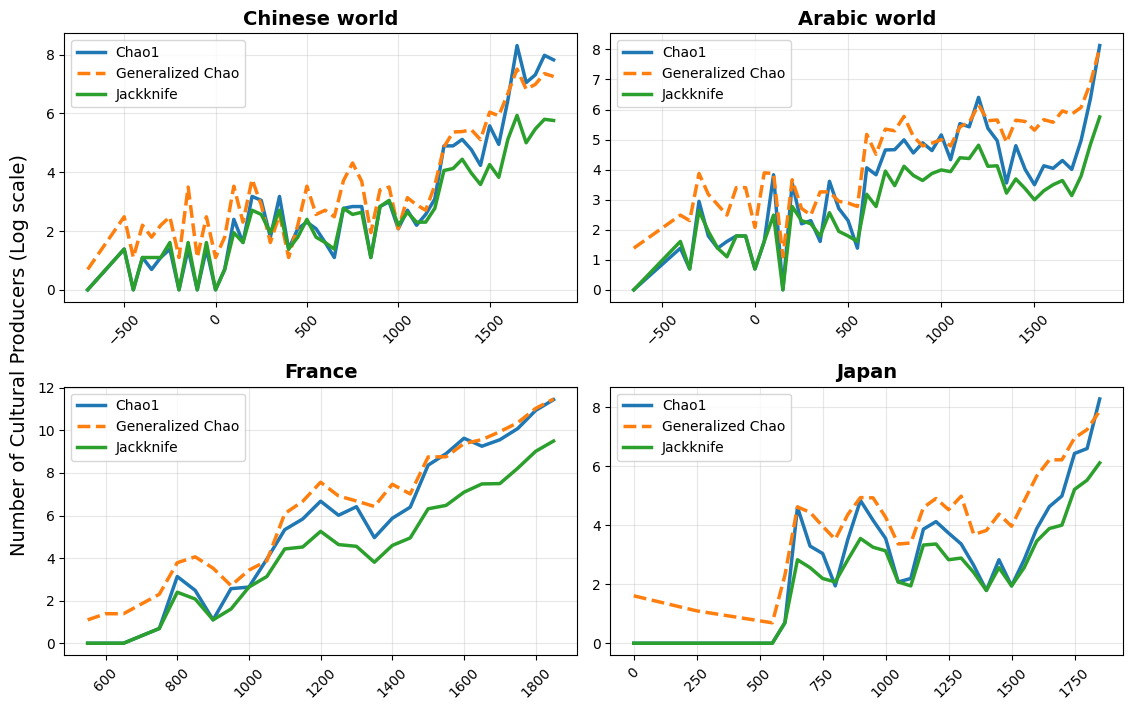

In [171]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.signal import savgol_filter

# Assuming df_plot is your original dataframe
# First filter to only include data from 1850 onwards

# Group by 50-year periods instead of decades
# Create a new column for the 50-year period

df_filtered = df_plot.copy()
df_filtered['period'] = (df_filtered['decade'] // 50) * 50

df_filtered = df_filtered[df_filtered['period'] <= 1850]

# Now group by this period instead of decade
df_regions = df_filtered.groupby(['region_name', 'period'])[['chao1', 'gen_chao', 'jackknife']].sum().reset_index()

# Select 4 interesting regions
regions_to_plot = ['Chinese world', 'Arabic world', 'France', 'Japan']

# Create a figure with subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
axes = axes.flatten()

# Set a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Function to apply smoothing
def smooth_data(y, window_size=5, poly_order=2):
    """Apply Savitzky-Golay filter for smoothing if enough data points"""
    if len(y) > window_size:
        # Make sure window_size is odd
        if window_size % 2 == 0:
            window_size += 1
        # Make sure poly_order < window_size
        poly_order = min(poly_order, window_size-1)
        return savgol_filter(y, window_size, poly_order)
    else:
        # Not enough points for smoothing, return original data
        return y

# Loop through the selected regions
for i, region in enumerate(regions_to_plot):
    # Filter data for this region
    region_data = df_regions[df_regions['region_name'] == region].sort_values('period')
    
    # Skip if no data
    if len(region_data) == 0:
        axes[i].text(0.5, 0.5, f"No data for {region}", 
                     ha='center', va='center', fontsize=14)
        continue
    
    periods = region_data['period'].values
    
    # Get the original values
    chao1 = region_data['chao1'].values
    gen_chao = region_data['gen_chao'].values
    jackknife = region_data['jackknife'].values
    
    # Apply log transformation to all values
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    chao1_log = np.log(chao1 + epsilon)
    jackknife_log = np.log(jackknife + epsilon)
    gen_chao_log = np.log(gen_chao + epsilon)
    
    # Plot the log-transformed lines
    axes[i].plot(periods, chao1_log, color=colors[0], linewidth=2.5, label='Chao1')
    axes[i].plot(periods, gen_chao_log, color=colors[1], linewidth=2.5, linestyle='--', label='Generalized Chao')
    axes[i].plot(periods, jackknife_log, color=colors[2], linewidth=2.5, label='Jackknife')
    
    # Set title
    axes[i].set_title(f"{region}", fontsize=14, fontweight='bold')
    
    # Set the x-axis label for each subplot
    axes[i].set_xlabel('', fontsize=12)
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add legend
    axes[i].legend(loc='upper left')
    
    # Add grid for better readability
    axes[i].grid(True, alpha=0.3)

# Add a single y-axis label for the entire figure
fig.text(0.05, 0.5, 'Number of Cultural Producers (Log scale)', va='center', rotation='vertical', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0.06, 0.05, 0.99, 0.95])  # Make space for the common y-axis label

# Show plot
plt.show()

In [172]:

df_estimator = df_plot.groupby(['region_name']).agg({'gen_chao':'sum','chao1':'sum', 
                                                  'jackknife':'sum', 
                                                  'ichao1':'sum', 
                                                #   'ace':'sum', 
                                                #   'egghe_proot':'sum',
                                                  'f1':'sum', 
                                                  'f2':'sum', 
                                                  'n':'sum'}).reset_index()


df_estimator = df_estimator.drop('gen_chao', axis=1)
df_estimator = pd.merge(df_estimator, df_gen_chao_regions, on = 'region_name')
df_estimator

,region_name,chao1,jackknife,ichao1,f1,f2,n,gen_chao
0,Arabic world,7317,1687,7317,1122,80,1282,9814
1,Central Europe,231145,14326,231145,8295,205,8705,335099
2,Chinese world,14139,2269,14139,1380,124,1628,10605
3,France,229179,32301,229179,16719,1122,18963,264692
4,German world,1060441,53619,1060441,28382,957,30296,932397
5,Greek World,6241,1489,6241,1045,58,1161,14033
6,Indian world,1593,543,1593,378,34,446,3462
7,Italy,307258,24455,307258,13671,554,14779,411813
8,Japan,6325,1339,6325,886,63,1012,8482
9,Korea,301,201,301,169,10,189,1894


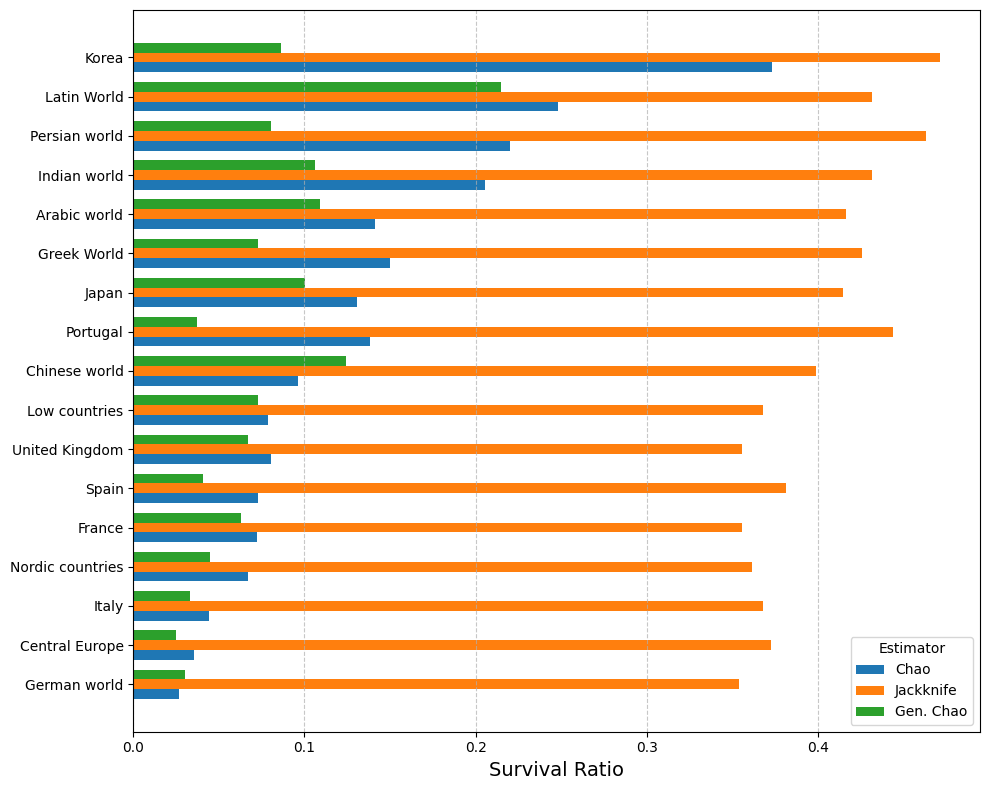

In [173]:


df_estimator['total_chao'] = df_estimator['chao1'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['total_jackknife'] = df_estimator['jackknife'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['total_gen_chao'] = df_estimator['gen_chao'] + df_estimator['f1']+ df_estimator['f2']
df_estimator['S_obs'] = df_estimator['f1']+df_estimator['f2']

df_estimator['survival_ratio_chao']=df_estimator['S_obs']/df_estimator['total_chao']
df_estimator['survival_ratio_jackknife']=df_estimator['S_obs']/df_estimator['total_jackknife']
df_estimator['survival_ratio_gen_chao']=df_estimator['S_obs']/df_estimator['total_gen_chao']



import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract relevant columns for plotting
plot_data = df_estimator[['region_name', 'survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']]

# Sort regions by average survival ratio
plot_data['avg_survival'] = plot_data[['survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']].mean(axis=1)
sorted_regions = plot_data.sort_values('avg_survival', ascending=True)['region_name'].tolist()

# Set up the figure
plt.figure(figsize=(10, 8))

# Set positions and width
y_positions = np.arange(len(sorted_regions))
width = 0.25

# Plot each estimator
plt.barh(y_positions - width, 
         [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_chao'].values[0] for region in sorted_regions], 
         height=width, label='Chao', color='#1f77b4')

plt.barh(y_positions, 
         [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_jackknife'].values[0] for region in sorted_regions], 
         height=width, label='Jackknife', color='#ff7f0e')

plt.barh(y_positions + width, 
         [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_gen_chao'].values[0] for region in sorted_regions], 
         height=width, label='Gen. Chao', color='#2ca02c')

# Set y-axis ticks and labels
plt.yticks(y_positions, sorted_regions)

# Add labels and title
plt.xlabel('Survival Ratio', fontsize=14)
plt.title('', fontsize=16)

# Add a legend
plt.legend(title='Estimator', loc='lower right')

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

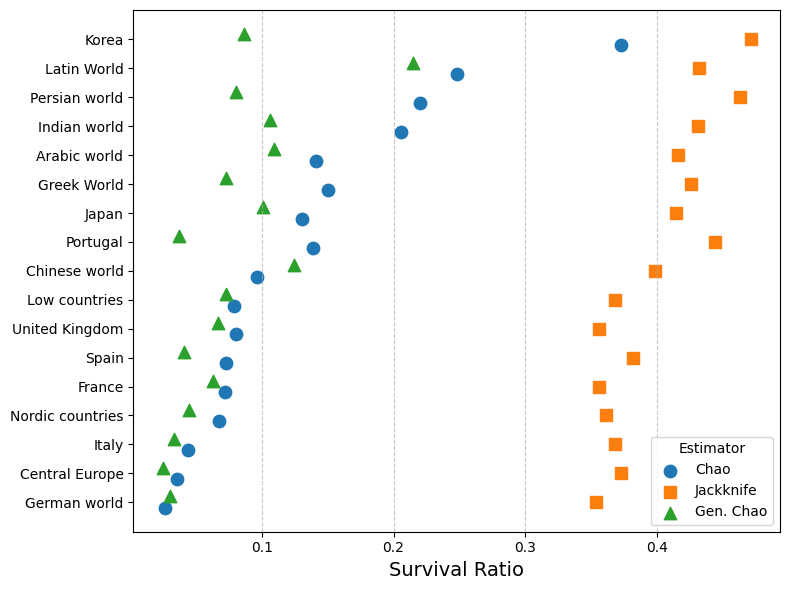

In [174]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract relevant columns for plotting
plot_data = df_estimator[['region_name', 'survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']]
plot_data = plot_data[~plot_data['region_name'].isin(remove_regions)]

# Sort regions by average survival ratio
plot_data['avg_survival'] = plot_data[['survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']].mean(axis=1)
sorted_regions = plot_data.sort_values('avg_survival', ascending=True)['region_name'].tolist()

# Set up the figure
plt.figure(figsize=(8, 6))

# Set positions
y_positions = np.arange(len(sorted_regions))
offset = 0.2  # Offset between points

# Get the values for each estimator
chao_values = [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_chao'].values[0] for region in sorted_regions]
jackknife_values = [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_jackknife'].values[0] for region in sorted_regions]
gen_chao_values = [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_gen_chao'].values[0] for region in sorted_regions]

# Plot each estimator with points
plt.scatter(chao_values, y_positions - offset, s=80, label='Chao', color='#1f77b4', marker='o')
plt.scatter(jackknife_values, y_positions, s=80, label='Jackknife', color='#ff7f0e', marker='s')
plt.scatter(gen_chao_values, y_positions + offset, s=80, label='Gen. Chao', color='#2ca02c', marker='^')

# Set y-axis ticks and labels
plt.yticks(y_positions, sorted_regions)

# Add labels and title
plt.xlabel('Survival Ratio', fontsize=14)

# Add a legend
plt.legend(title='Estimator', loc='lower right')

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

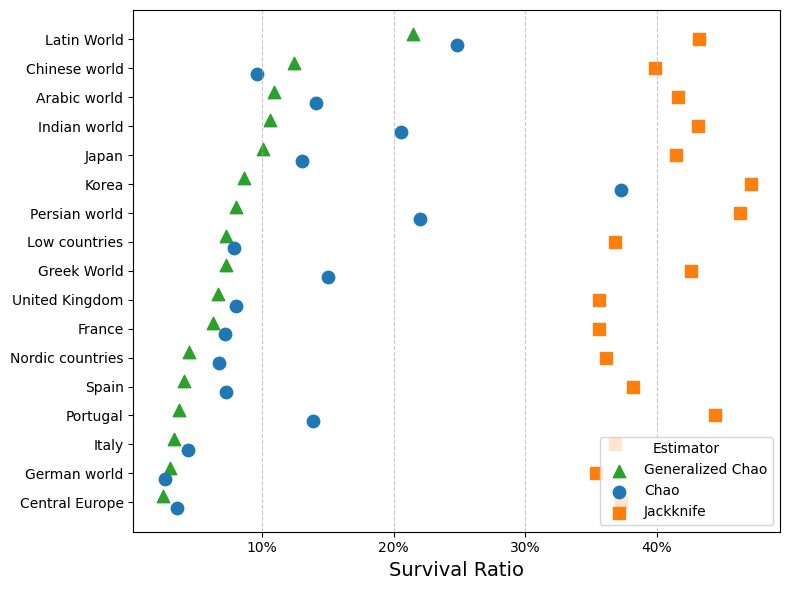

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter

# Extract relevant columns for plotting
plot_data = df_estimator[['region_name', 'survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']]
plot_data = plot_data[~plot_data['region_name'].isin(remove_regions)]

# Sort regions by Generalized Chao survival ratio
sorted_regions = plot_data.sort_values('survival_ratio_gen_chao', ascending=True)['region_name'].tolist()

# Set up the figure
plt.figure(figsize=(8, 6))

# Set positions
y_positions = np.arange(len(sorted_regions))
offset = 0.2  # Offset between points

# Get the values for each estimator
chao_values = [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_chao'].values[0] for region in sorted_regions]
jackknife_values = [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_jackknife'].values[0] for region in sorted_regions]
gen_chao_values = [plot_data.loc[plot_data['region_name'] == region, 'survival_ratio_gen_chao'].values[0] for region in sorted_regions]

# Plot each estimator with points - changing the order of plotting to match desired legend order
plt.scatter(gen_chao_values, y_positions + offset, s=80, label='Generalized Chao', color='#2ca02c', marker='^')
plt.scatter(chao_values, y_positions - offset, s=80, label='Chao', color='#1f77b4', marker='o')
plt.scatter(jackknife_values, y_positions, s=80, label='Jackknife', color='#ff7f0e', marker='s')

# Set y-axis ticks and labels
plt.yticks(y_positions, sorted_regions)

# Format x-axis as percentages
def percent_formatter(x, pos):
    return f'{x:.0%}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Add labels and title
plt.xlabel('Survival Ratio', fontsize=14)

# Add a legend with the desired order
plt.legend(title='Estimator', loc='lower right')

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Correlations

Correlation Matrix:
                          survival_ratio_chao  survival_ratio_jackknife  \
survival_ratio_chao                      1.00                      0.88   
survival_ratio_jackknife                 0.88                      1.00   
survival_ratio_gen_chao                  0.57                      0.45   

                          survival_ratio_gen_chao  
survival_ratio_chao                          0.57  
survival_ratio_jackknife                     0.45  
survival_ratio_gen_chao                      1.00  


Pairwise Correlations:
Chao vs Jackknife: 0.881
Chao vs Generalized Chao: 0.570
Jackknife vs Generalized Chao: 0.450


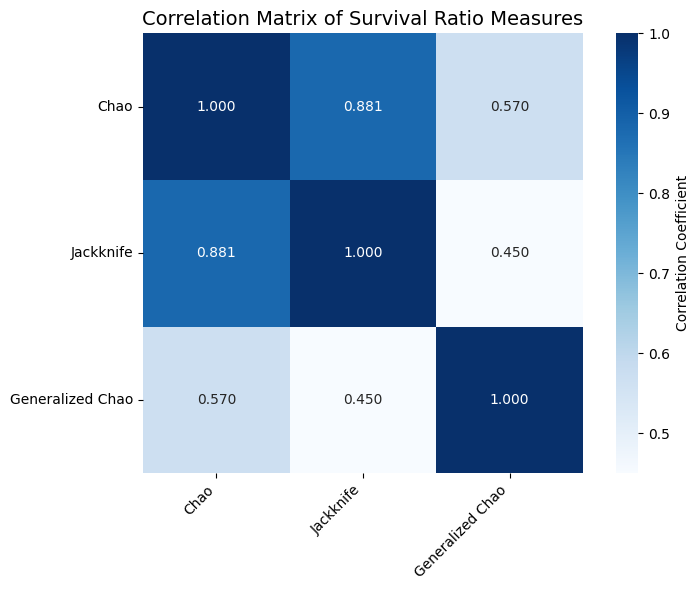


Descriptive Statistics:
       survival_ratio_chao  survival_ratio_jackknife  survival_ratio_gen_chao
count                17.00                     17.00                    17.00
mean                  0.13                      0.40                     0.08
std                   0.09                      0.04                     0.05
min                   0.03                      0.35                     0.02
25%                   0.07                      0.37                     0.04
50%                   0.10                      0.40                     0.07
75%                   0.15                      0.43                     0.10
max                   0.37                      0.47                     0.21


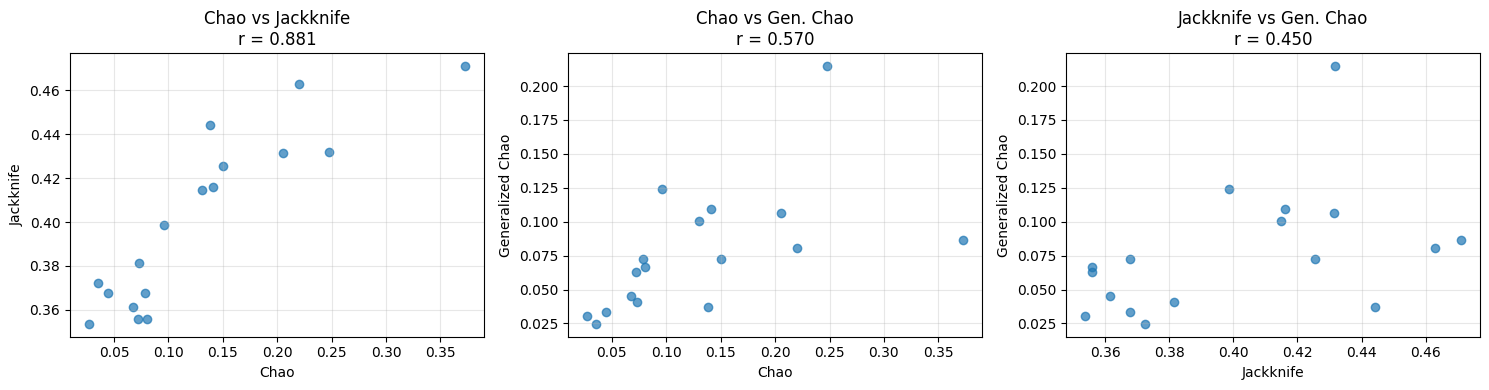

Correlation Matrix:
                          survival_ratio_chao  survival_ratio_jackknife  \
survival_ratio_chao                      1.00                      0.88   
survival_ratio_jackknife                 0.88                      1.00   
survival_ratio_gen_chao                  0.57                      0.45   

                          survival_ratio_gen_chao  
survival_ratio_chao                          0.57  
survival_ratio_jackknife                     0.45  
survival_ratio_gen_chao                      1.00  


Pairwise Correlations:
Chao vs Jackknife: 0.881
Chao vs Generalized Chao: 0.570
Jackknife vs Generalized Chao: 0.450


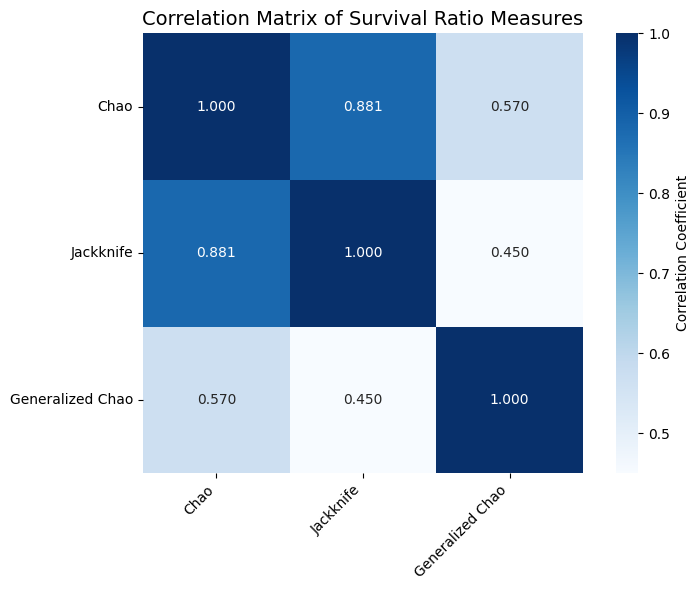


Descriptive Statistics:
       survival_ratio_chao  survival_ratio_jackknife  survival_ratio_gen_chao
count                17.00                     17.00                    17.00
mean                  0.13                      0.40                     0.08
std                   0.09                      0.04                     0.05
min                   0.03                      0.35                     0.02
25%                   0.07                      0.37                     0.04
50%                   0.10                      0.40                     0.07
75%                   0.15                      0.43                     0.10
max                   0.37                      0.47                     0.21


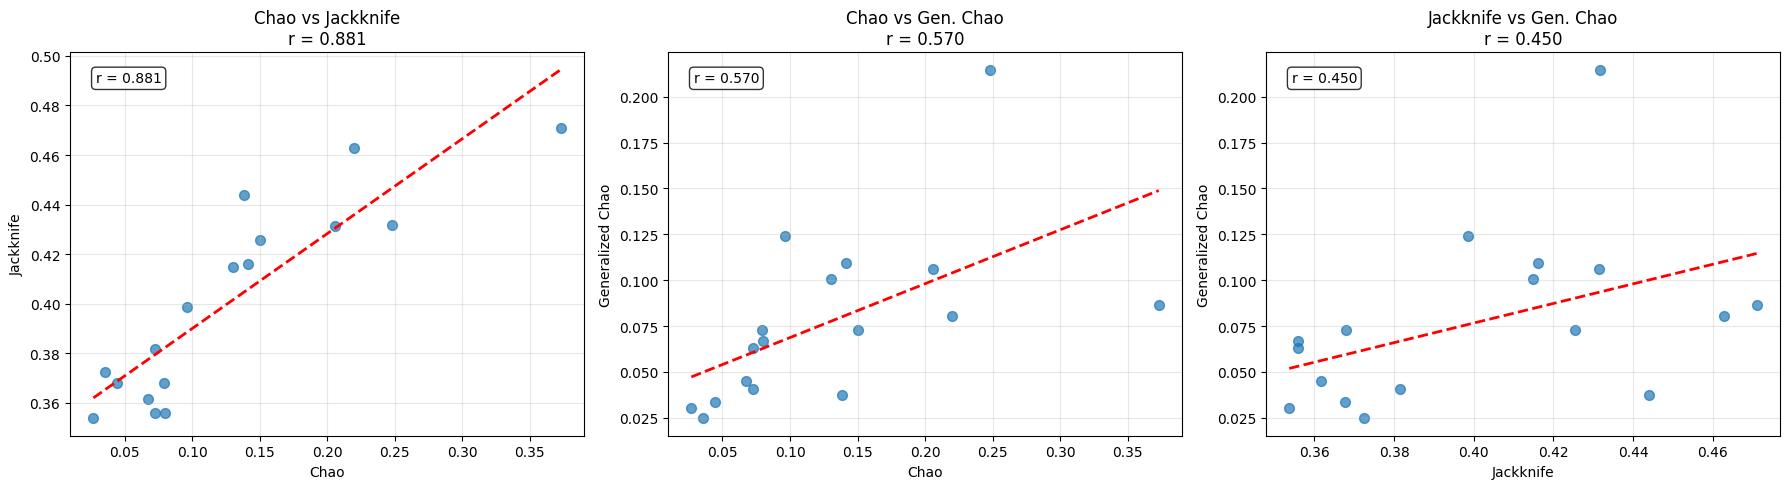


Regression Statistics:

Chao Vs Jackknife:
  Slope: 0.3833
  Intercept: 0.3516
  R-squared: 0.7768
  P-value: 2.95e-06
  Significance: highly significant (p < 0.001)

Chao Vs Gen Chao:
  Slope: 0.2936
  Intercept: 0.0394
  R-squared: 0.3245
  P-value: 1.70e-02
  Significance: significant (p < 0.05)

Jackknife Vs Gen Chao:
  Slope: 0.5335
  Intercept: -0.1368
  R-squared: 0.2027
  P-value: 6.98e-02
  Significance: not significant (p ≥ 0.05)

Alternative: Seaborn Regression Plots


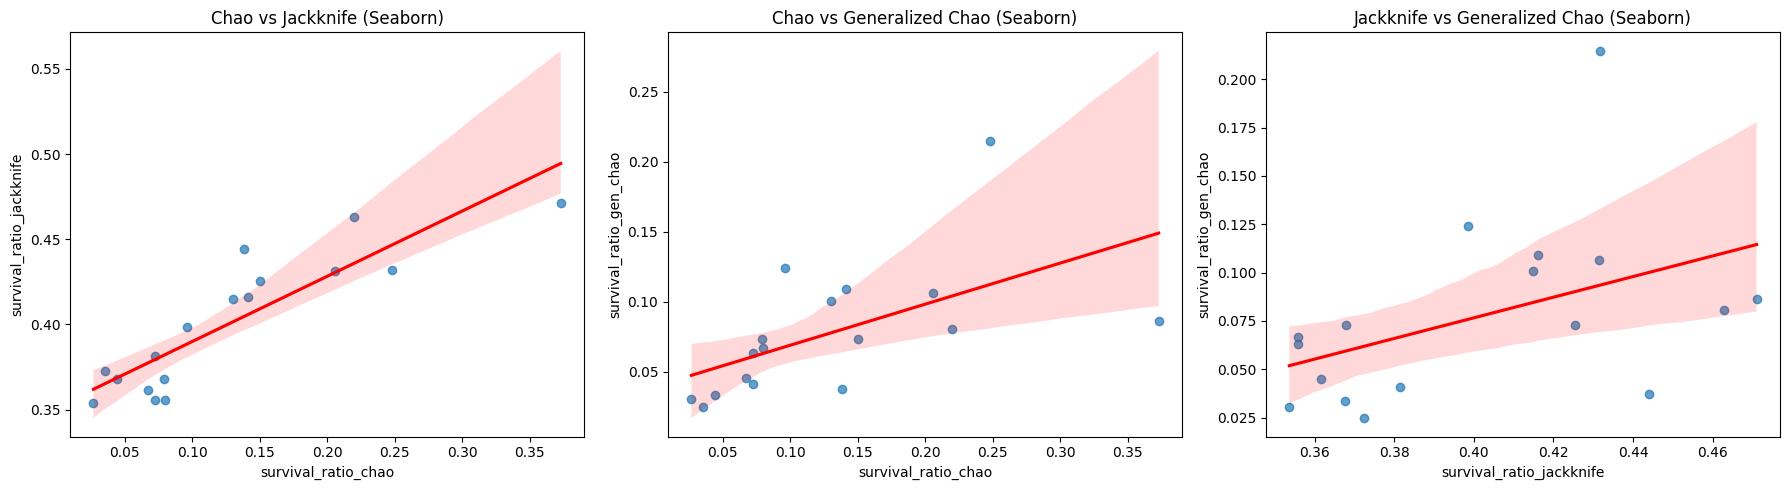

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

# Extract the three survival ratio columns
survival_measures = plot_data[['survival_ratio_chao', 'survival_ratio_jackknife', 'survival_ratio_gen_chao']]

# Compute correlation matrix
correlation_matrix = survival_measures.corr()

print("Correlation Matrix:")
print(correlation_matrix)
print("\n")

# Print pairwise correlations with more detail
print("Pairwise Correlations:")
print(f"Chao vs Jackknife: {correlation_matrix.loc['survival_ratio_chao', 'survival_ratio_jackknife']:.3f}")
print(f"Chao vs Generalized Chao: {correlation_matrix.loc['survival_ratio_chao', 'survival_ratio_gen_chao']:.3f}")
print(f"Jackknife vs Generalized Chao: {correlation_matrix.loc['survival_ratio_jackknife', 'survival_ratio_gen_chao']:.3f}")

# Create a correlation heatmap
plt.figure(figsize=(8, 6))

# Rename the columns for better display
correlation_matrix_display = correlation_matrix.copy()
correlation_matrix_display.index = ['Chao', 'Jackknife', 'Generalized Chao']
correlation_matrix_display.columns = ['Chao', 'Jackknife', 'Generalized Chao']

sns.heatmap(correlation_matrix_display, 
            annot=True, 
            cmap='Blues', 
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Correlation Coefficient'},
            xticklabels=True,
            yticklabels=True)

plt.title('Correlation Matrix of Survival Ratio Measures', fontsize=14)
plt.xlabel('')
plt.ylabel('')

# Fix tick positioning - they should be centered automatically with xticklabels=True
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Optional: Compute additional statistics
print("\nDescriptive Statistics:")
print(survival_measures.describe())

# Function to add regression line and statistics
def add_regression_line(ax, x, y, color='red'):
    """Add regression line with statistics to scatter plot"""
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) > 1:
        # Calculate regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
        
        # Create regression line
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_line = slope * x_line + intercept
        
        # Plot regression line (without equation label)
        ax.plot(x_line, y_line, color=color, linewidth=2, linestyle='--')
        
        # Add correlation coefficient to the plot
        ax.text(0.05, 0.95, f'r = {r_value:.3f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        return slope, intercept, r_value, p_value, std_err
    return None, None, None, None, None

# Create scatter plots with regression lines for pairwise relationships
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Store regression statistics
regression_stats = {}

# Chao vs Jackknife
x1 = survival_measures['survival_ratio_chao'].values
y1 = survival_measures['survival_ratio_jackknife'].values
axes[0].scatter(x1, y1, alpha=0.7, s=50)
slope1, intercept1, r1, p1, se1 = add_regression_line(axes[0], x1, y1)
regression_stats['chao_vs_jackknife'] = {'slope': slope1, 'intercept': intercept1, 'r': r1, 'p': p1}

axes[0].set_xlabel('Chao')
axes[0].set_ylabel('Jackknife')
axes[0].set_title(f'Chao vs Jackknife\nr = {correlation_matrix.loc["survival_ratio_chao", "survival_ratio_jackknife"]:.3f}')
axes[0].grid(True, alpha=0.3)

# Chao vs Generalized Chao
x2 = survival_measures['survival_ratio_chao'].values
y2 = survival_measures['survival_ratio_gen_chao'].values
axes[1].scatter(x2, y2, alpha=0.7, s=50)
slope2, intercept2, r2, p2, se2 = add_regression_line(axes[1], x2, y2)
regression_stats['chao_vs_gen_chao'] = {'slope': slope2, 'intercept': intercept2, 'r': r2, 'p': p2}

axes[1].set_xlabel('Chao')
axes[1].set_ylabel('Generalized Chao')
axes[1].set_title(f'Chao vs Gen. Chao\nr = {correlation_matrix.loc["survival_ratio_chao", "survival_ratio_gen_chao"]:.3f}')
axes[1].grid(True, alpha=0.3)

# Jackknife vs Generalized Chao
x3 = survival_measures['survival_ratio_jackknife'].values
y3 = survival_measures['survival_ratio_gen_chao'].values
axes[2].scatter(x3, y3, alpha=0.7, s=50)
slope3, intercept3, r3, p3, se3 = add_regression_line(axes[2], x3, y3)
regression_stats['jackknife_vs_gen_chao'] = {'slope': slope3, 'intercept': intercept3, 'r': r3, 'p': p3}

axes[2].set_xlabel('Jackknife')
axes[2].set_ylabel('Generalized Chao')
axes[2].set_title(f'Jackknife vs Gen. Chao\nr = {correlation_matrix.loc["survival_ratio_jackknife", "survival_ratio_gen_chao"]:.3f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print regression statistics
print("\nRegression Statistics:")
print("=" * 50)
for comparison, stats_dict in regression_stats.items():
    if stats_dict['slope'] is not None:
        print(f"\n{comparison.replace('_', ' ').title()}:")
        print(f"  Slope: {stats_dict['slope']:.4f}")
        print(f"  Intercept: {stats_dict['intercept']:.4f}")
        print(f"  R-squared: {stats_dict['r']**2:.4f}")
        print(f"  P-value: {stats_dict['p']:.2e}")
        
        # Interpretation
        if stats_dict['p'] < 0.001:
            significance = "highly significant (p < 0.001)"
        elif stats_dict['p'] < 0.01:
            significance = "significant (p < 0.01)"
        elif stats_dict['p'] < 0.05:
            significance = "significant (p < 0.05)"
        else:
            significance = "not significant (p ≥ 0.05)"
        print(f"  Significance: {significance}")

# Alternative: Using seaborn for regression plots (optional)
print("\n" + "="*50)
print("Alternative: Seaborn Regression Plots")
print("="*50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Create data for seaborn
plot_df = survival_measures.copy()

# Seaborn regression plots
sns.regplot(data=plot_df, x='survival_ratio_chao', y='survival_ratio_jackknife', 
            ax=axes[0], scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})
axes[0].set_title('Chao vs Jackknife (Seaborn)')

sns.regplot(data=plot_df, x='survival_ratio_chao', y='survival_ratio_gen_chao', 
            ax=axes[1], scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})
axes[1].set_title('Chao vs Generalized Chao (Seaborn)')

sns.regplot(data=plot_df, x='survival_ratio_jackknife', y='survival_ratio_gen_chao', 
            ax=axes[2], scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})
axes[2].set_title('Jackknife vs Generalized Chao (Seaborn)')

plt.tight_layout()
plt.show()

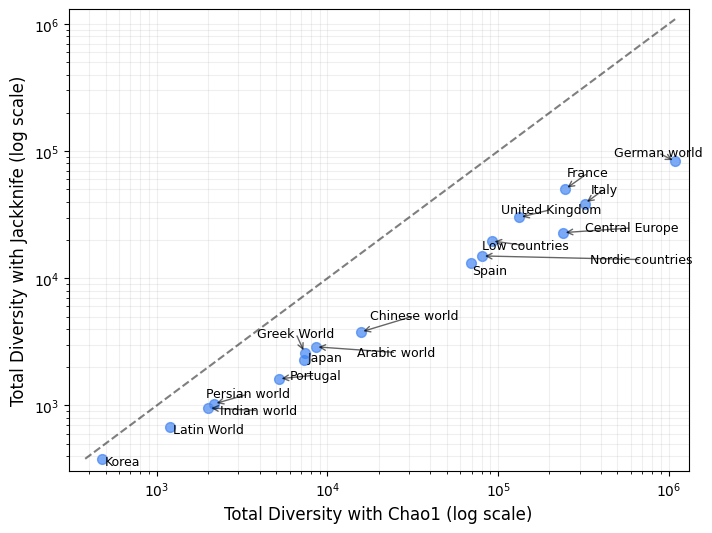

In [177]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  # This might need to be installed with pip install adjustText

# Filter out regions with "North" and "South" in their names
main_regions = [region for region in df_estimator['region_name'] 
               if not any(direction in region for direction in ["North", "South"])]
df_main = df_estimator[df_estimator['region_name'].isin(main_regions)]

# Create a figure for the log-scale scatter plot
plt.figure(figsize=(8, 6))  # Slightly larger figure to accommodate all labels

# Create scatter plot with larger points
scatter = plt.scatter(df_main['total_chao'], df_main['total_jackknife'], alpha=0.7, s=50, color='#4285F4')

# Set log scales for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Total Diversity with Chao1 (log scale)', fontsize=12)
plt.ylabel('Total Diversity with Jackknife (log scale)', fontsize=12)

# Add a reference line (where Chao = Jackknife)
max_val = max(df_estimator['total_chao'].max(), df_estimator['total_jackknife'].max())
min_val = min(df_estimator['total_chao'].min(), df_estimator['total_jackknife'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# Create text annotations but don't add them yet
texts = []
for i, row in df_main.iterrows():
    texts.append(plt.text(row['total_chao'], row['total_jackknife'], row['region_name'], fontsize=9))

# Use adjust_text to prevent overlap
adjust_text(texts, 
           arrowprops=dict(arrowstyle='->', color='black', alpha=0.6),
           expand_points=(1.5, 1.5),
           force_points=(0.1, 0.1))

# Set axis limits with some padding
plt.xlim(min_val * 0.8, max_val * 1.2)
plt.ylim(min_val * 0.8, max_val * 1.2)

# Add grid for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Alternative approach if adjustText is not available:
# This manual approach uses specific positioning for problem regions



In [178]:
# compare chao1 and show that generalized chao is higher
# if not, it means that the model is not doing what it is supposed to do